# ##Video LinK : 

In [50]:
# IMDB Reviews Analysis Project

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer, TFBertForSequenceClassification,TFDistilBertForSequenceClassification,TFAutoModelForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import cpu_count
from pandarallel import pandarallel
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [3]:
# Load the dataset
df = pd.read_csv('Imdb.csv')


In [5]:
# Data Exploration
print(df.head())
print(df.info())
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [7]:

# Check for missing values
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


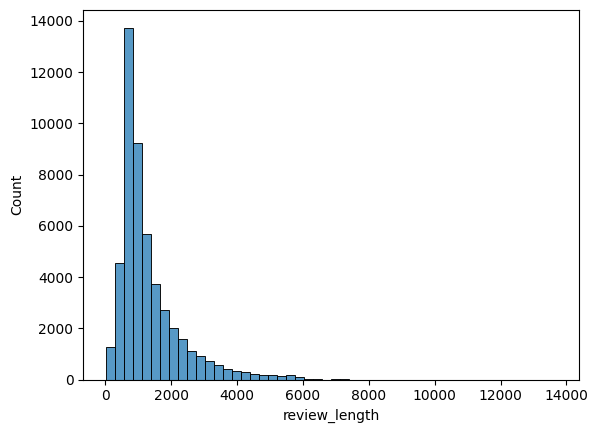

In [9]:
# Analyzing the length of reviews
df['review_length'] = df['review'].apply(len)
sns.histplot(df['review_length'], bins=50)
plt.show()

In [11]:
# Text Preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\232pa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\232pa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [15]:
pandarallel.initialize()
df['cleaned_review'] = df['review'].apply(preprocess_text)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [17]:
# Vectorization
cv = CountVectorizer(max_features=5000)
tfidf = TfidfVectorizer(max_features=5000)
X_cv = cv.fit_transform(df['cleaned_review']).toarray()
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [19]:
# Tokenization for LSTM
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_pad = pad_sequences(X_seq, maxlen=max_len)


In [20]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [23]:
# Model Development
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier()
}


In [25]:
best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'--- {name} ---')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}\n')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = name

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.8877
F1 Score: 0.8899990204721324
ROC AUC Score: 0.8875909810352862

--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy: 0.8513
F1 Score: 0.8534542229230314
ROC AUC Score: 0.8512371292669446

--- SVM ---
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1   

In [27]:
# Optimized LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=64,),
    SpatialDropout1D(0.2),
    LSTM(50, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32, validation_data=(X_test_seq, y_test_seq))


Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 104ms/step - accuracy: 0.7701 - loss: 0.4670 - val_accuracy: 0.8857 - val_loss: 0.2853
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8896 - loss: 0.2814 - val_accuracy: 0.8771 - val_loss: 0.2966


In [45]:
# Optimized BERT Model using DistilBERT
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
input_ids = bert_tokenizer(df['cleaned_review'].tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')['input_ids']

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(input_ids.numpy(), y, test_size=0.2, random_state=42)
from tensorflow.keras.optimizers import Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

bert_model.fit(X_train_bert, y_train_bert, epochs=1, batch_size=8, validation_data=(X_test_bert, y_test_bert))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x000001D52E8AF9E0>

In [47]:
# Best Model Selection
print(f'The best ML model based on accuracy is: {best_model} with accuracy of {best_accuracy}')


The best ML model based on accuracy is: Logistic Regression with accuracy of 0.8877
